### Google Analytics 4 API - Analyzing my blog page data: [emrecanduran.com](https://emrecanduran.com)

In [1]:
# Data and Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Date and Time
from datetime import date
from datetime import timedelta

# Google Analytics
import os
from google.analytics.data_v1beta import BetaAnalyticsDataClient
from google.analytics.data_v1beta.types import DateRange
from google.analytics.data_v1beta.types import Dimension
from google.analytics.data_v1beta.types import Metric
from google.analytics.data_v1beta.types import RunReportRequest
from google.analytics.data_v1beta.types import OrderBy

#### Set up global variables

In [2]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = 'ga4data-1697287110753-7409c9ffa28c.json'
property_id = 'GA4_propery_id' 

client = BetaAnalyticsDataClient()

#### Run report

In [3]:
def format_report(request):
    response = client.run_report(request)
    
    # Row index
    row_index_names = [header.name for header in response.dimension_headers]
    row_header = []
    for i in range(len(row_index_names)):
        row_header.append([row.dimension_values[i].value for row in response.rows])

    row_index_named = pd.MultiIndex.from_arrays(np.array(row_header), names = np.array(row_index_names))
    
    # Row flat data
    metric_names = [header.name for header in response.metric_headers]
    data_values = []
    for i in range(len(metric_names)):
        data_values.append([row.metric_values[i].value for row in response.rows])

    output = pd.DataFrame(data = np.transpose(np.array(data_values, dtype = 'f')), 
                          index = row_index_named, columns = metric_names)
    return output

### Monthly New User, Active User, and Session Metrics Comparison

In [4]:
start_date = '2023-01-01'
end_date = '2023-06-30'

In [5]:
# Run report
monthly_metrics_comparison_request = RunReportRequest(
        property='properties/'+property_id,
        dimensions=[Dimension(name="month")],
        metrics=[Metric(name="newUsers"), 
                 Metric(name="activeUsers"),
                 Metric(name='sessions')],
        order_bys = [OrderBy(dimension = {'dimension_name': 'month'}, desc=False)],
        date_ranges=[DateRange(start_date=start_date, end_date=end_date)],
    )

monthly_metrics_comparison_request

property: "properties/343225696"
dimensions {
  name: "month"
}
metrics {
  name: "newUsers"
}
metrics {
  name: "activeUsers"
}
metrics {
  name: "sessions"
}
date_ranges {
  start_date: "2023-01-01"
  end_date: "2023-06-30"
}
order_bys {
  dimension {
    dimension_name: "month"
  }
}

In [6]:
monthly_metrics_comparison = format_report(monthly_metrics_comparison_request)

# Export & load the data
monthly_metrics_comparison.reset_index().to_excel('Monthly_metrics_comparison.xlsx', sheet_name = 'GA4_report_monthly_metrics', engine = 'xlsxwriter')
monthly_metrics_comparison = pd.read_excel('Monthly_metrics_comparison.xlsx')

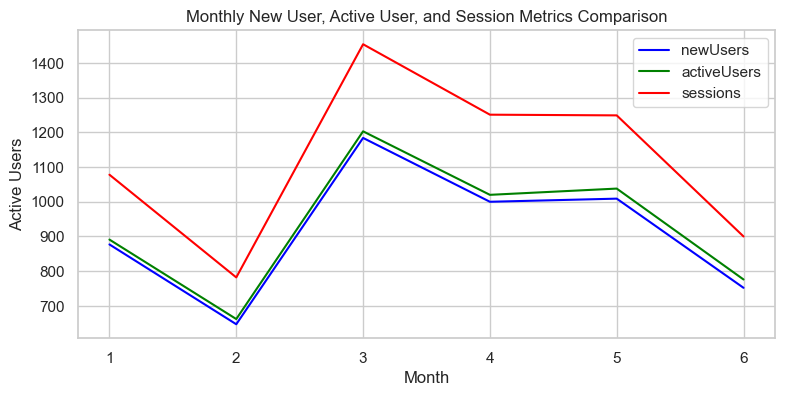

In [187]:
plt.figure(figsize=(9, 4))

metrics = ['newUsers', 'activeUsers', 'sessions'] 
colors = {'newUsers': 'blue', 'activeUsers': 'green', 'sessions': 'red'}

for metric in metrics: 
    sns.lineplot(data=monthly_metrics_comparison, x='month', y=metric, label=metric, color=colors[metric])
    
plt.xlabel('Month')
plt.ylabel('Active Users')
plt.title('Monthly New User, Active User, and Session Metrics Comparison')
plt.legend()
plt.grid(True)
plt.show()

- New users: The number of users who interacted with your site or launched your app for the first time (event triggered: first_open or first_visit). 

- Active users: The number of distinct users who visited your site or app.

- Sessions: The number of sessions that began on your site or app (event triggered: session_start).

### Top 15 Landing Pages by Active Users

In [41]:
# Run report
landing_page_users_request = RunReportRequest(
        property='properties/'+property_id,
        dimensions=[Dimension(name="landingPage")],
        metrics=[Metric(name="activeUsers"),
                 Metric(name="bounceRate")],
        order_bys = [OrderBy(dimension = {'dimension_name': 'activeUsers'}, desc=True)],
        date_ranges=[DateRange(start_date=start_date, end_date=end_date)],
    )

landing_page_users_request

property: "properties/343225696"
dimensions {
  name: "landingPage"
}
metrics {
  name: "activeUsers"
}
metrics {
  name: "bounceRate"
}
date_ranges {
  start_date: "2023-01-01"
  end_date: "2023-06-30"
}
order_bys {
  dimension {
    dimension_name: "activeUsers"
  }
  desc: true
}

In [42]:
landing_table = format_report(landing_page_users_request)
landing_table['activeUsers'] = landing_table['activeUsers'].astype('int')

print('\nTop 15 Landing Pages and, its Bounce Rate')
display(landing_table[0:15]) 


Top 15 Landing Pages and, its Bounce Rate


,activeUsers,bounceRate
landingPage,,
/2021/06/02/mail-nasil-yazilir,755,0.250000
/2020/02/22/erasmus-staj-programi-hollanda,651,0.139163
/2019/12/29/nedir-bu-aiesec,622,0.129078
/2020/02/26/erasmus-programi-romanya,613,0.123367
/2021/02/07/europass-cv-nasil-hazirlanir,551,0.081731
(not set),331,0.883827
/2020/04/29/erasmus-staj-programi-ingiltere,272,0.141379
/2021/04/25/motivasyon-mektubu-nasil-yazilir,253,0.144330
,236,0.721831


#### While you can see bounce rate in UA, this feature has been removed in GA4. You have to create a report in GA4 to see it.

- Landing page: The page path associated with the first pageview in a session.

- Bounce rate: The percentage of sessions that were not engaged ((Sessions Minus Engaged sessions) divided by Sessions). This metric is returned as a fraction; for example, 0.2761 means 27.61% of sessions were bounces.

### Events Comparison

In [43]:
# Run report
event_request = RunReportRequest(
        property='properties/'+property_id,
        dimensions=[Dimension(name="eventName")],
        metrics=[Metric(name="activeUsers")],
        order_bys = [OrderBy(dimension = {'dimension_name': 'activeUsers'}, desc=True)],
        date_ranges=[DateRange(start_date=start_date, end_date=end_date)],
    )

event_request

property: "properties/343225696"
dimensions {
  name: "eventName"
}
metrics {
  name: "activeUsers"
}
date_ranges {
  start_date: "2023-01-01"
  end_date: "2023-06-30"
}
order_bys {
  dimension {
    dimension_name: "activeUsers"
  }
  desc: true
}

In [44]:
event_comparison = format_report(event_request)

# Export & load the data
event_comparison.reset_index().to_excel('event_comparison.xlsx', sheet_name = 'GA4_report_event', engine = 'xlsxwriter')
event_comparison = pd.read_excel('event_comparison.xlsx')

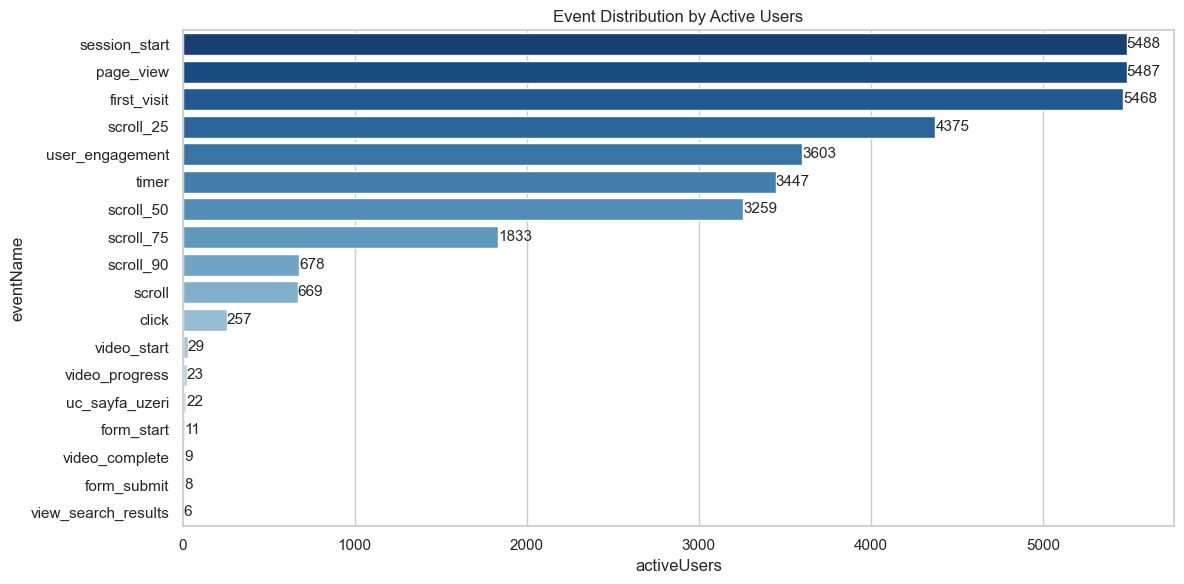

In [186]:
plt.figure(figsize=(12,6))
sns.set(style="whitegrid")

ax = sns.barplot(data=event_comparison, x='activeUsers', y='eventName',estimator="sum", palette='Blues_r')
ax.bar_label(ax.containers[0], fontsize=11);

plt.title('Event Distribution by Active Users')
plt.tight_layout()

### Monthly Traffic Chart

In [101]:
# Run report
traffic_request = RunReportRequest(
        property='properties/'+property_id,
        dimensions=[Dimension(name="month"), 
                    Dimension(name="sessionMedium")],
        metrics=[Metric(name="averageSessionDuration"), 
                 Metric(name="activeUsers")],
        order_bys = [OrderBy(dimension = {'dimension_name': 'month'}),
                    OrderBy(dimension = {'dimension_name': 'sessionMedium'})],
        date_ranges=[DateRange(start_date=start_date, end_date=end_date)],
    )

traffic_request

property: "properties/343225696"
dimensions {
  name: "month"
}
dimensions {
  name: "sessionMedium"
}
metrics {
  name: "averageSessionDuration"
}
metrics {
  name: "activeUsers"
}
date_ranges {
  start_date: "2023-01-01"
  end_date: "2023-06-30"
}
order_bys {
  dimension {
    dimension_name: "month"
  }
}
order_bys {
  dimension {
    dimension_name: "sessionMedium"
  }
}

In [102]:
traffic_channels = format_report(traffic_request)

# Export & load the data
traffic_channels.reset_index().to_excel('traffic_channels.xlsx', sheet_name = 'GA4_report_traffic_channels', engine = 'xlsxwriter')
traffic_channels = pd.read_excel('traffic_channels.xlsx')

<Figure size 1000x400 with 0 Axes>

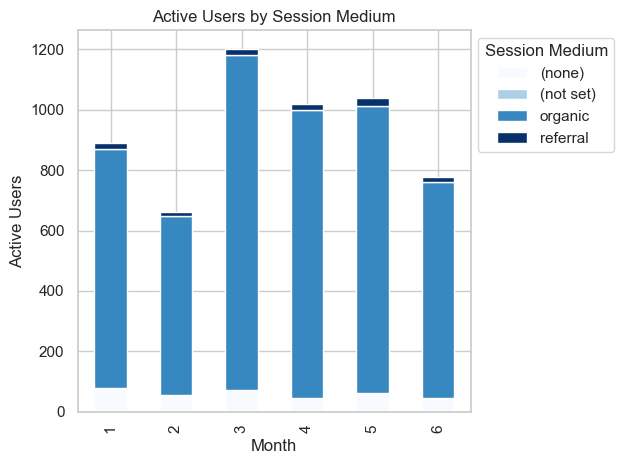

In [193]:
# Create a pivot table for the data
pivot_data = traffic_channels.pivot_table(index='month', columns='sessionMedium', values='activeUsers')

# Create the stacked bar plot
plt.figure(figsize=(10, 4))
sns.set(style="whitegrid")

ax = pivot_data.plot(kind='bar', stacked=True, colormap='Blues')

plt.xlabel("Month")
plt.ylabel("Active Users")
plt.title("Active Users by Session Medium")
plt.legend(title='Session Medium', loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

- Medium: The type of traffic.

### Device model, Age and, Gender 

In [ ]:
# Report request

mobileDeviceModel_request = RunReportRequest(
        property='properties/'+property_id,
        dimensions=[Dimension(name="mobileDeviceModel")],
        metrics=[Metric(name="activeUsers")],
        order_bys = [OrderBy(dimension = {'dimension_name': 'activeUsers'}, desc=True)],
        date_ranges=[DateRange(start_date=start_date, end_date=end_date)],
    )

userAgeBracket_request = RunReportRequest(
        property='properties/'+property_id,
        dimensions=[Dimension(name="userAgeBracket")],
        metrics=[Metric(name="activeUsers")],
        order_bys = [OrderBy(dimension = {'dimension_name': 'activeUsers'}, desc=True)],
        date_ranges=[DateRange(start_date=start_date, end_date=end_date)],
    ) 

userGender_request = RunReportRequest(
        property='properties/'+property_id,
        dimensions=[Dimension(name="userGender")],
        metrics=[Metric(name="activeUsers")],
        order_bys = [OrderBy(dimension = {'dimension_name': 'activeUsers'}, desc=True)],
        date_ranges=[DateRange(start_date=start_date, end_date=end_date)],
    ) 

mobileDeviceModel = format_report(mobileDeviceModel_request)
userAgeBracket = format_report(userAgeBracket_request)
gender = format_report(userGender_request)


# Export & load the data

mobileDeviceModel.reset_index().to_excel('mobileDeviceModel.xlsx', sheet_name = 'GA4_report_mobileDeviceModel', engine = 'xlsxwriter')
mobileDeviceModel = pd.read_excel('mobileDeviceModel.xlsx')

userAgeBracket.reset_index().to_excel('userAgeBracket.xlsx', sheet_name = 'GA4_report_userAgeBracket', engine = 'xlsxwriter')
userAgeBracket = pd.read_excel('userAgeBracket.xlsx')

gender.reset_index().to_excel('gender.xlsx', sheet_name = 'GA4_report_gender', engine = 'xlsxwriter')
gender = pd.read_excel('gender.xlsx')

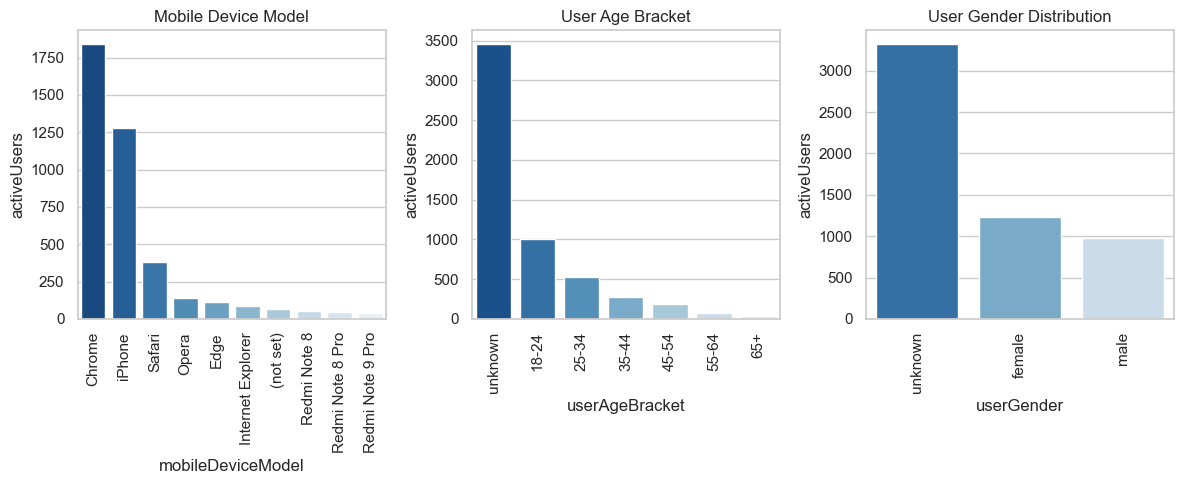

In [188]:
# Visualization

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 5))  # 1 row, 3 columns of subplots

palette = 'Blues_r'
rotation = 90

# Create barplots
top_10_mobile_models = mobileDeviceModel.nlargest(10, 'activeUsers')
sns.barplot(x='mobileDeviceModel', y='activeUsers', data=top_10_mobile_models, ax=axes[0], palette=palette)
axes[0].set_title('Mobile Device Model')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=rotation)

sns.barplot(x='userAgeBracket', y='activeUsers', data=userAgeBracket, ax=axes[1], palette=palette)
axes[1].set_title('User Age Bracket')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=rotation)

sns.barplot(x='userGender', y='activeUsers', data=gender, ax=axes[2], palette=palette)
axes[2].set_title('User Gender Distribution')
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=rotation)

plt.tight_layout()

plt.show()